In [37]:
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

from netCDF4 import Dataset



from Data import Data
from datetime import datetime


from scipy import stats

import scipy.stats as st


def spiParametersMle(x, dist=st.gamma):
    i = x == 0
    params = dist.fit(x[~i])
    q = len(x[i])/len(x)
    return(params, q)

def spiGeneratorMle(x, dist=st.gamma):
    i = x == 0

    params = dist.fit(x[~i])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    q = len(x[i])/len(x)
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

def spiGeneratorParamMle(x, params, q, dist=st.gamma):
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)
    
    if G == 1: G = 0.99
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)


def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

def deseasonalize_NoStd(data,freq=12):
    n  = data.shape[1]
    N  = data.shape[0]
    averages = np.zeros((freq,n))
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        result = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            averages[j,i] = temp[Idx].mean()
            result[Idx] = temp[Idx] - temp[Idx].mean()
        data_deseasonal[:,i] = result
    return(data_deseasonal,averages)


def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [99]:
level = 12
temporal_limits = {"time_min":datetime(1891, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}


#d = Data("../Cal_18912015.nc",'precip',temporal_limits,missing_value=-9.96921e+36)

#result = d.get_data()
cc = 'ZW'
result = np.load("{}_data_18912015.npy".format(cc))

result = pd.DataFrame(result)

In [103]:
r = result.iloc[:,100].rolling(rolling_n).apply(sum)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [105]:
r = r.iloc[rolling_n - 1:]

In [111]:
N = r.shape[0]

d3 = N - (n*f + 1)

In [118]:
k = 12

In [119]:
onset = k
end = k + (n*f - (rolling_n - 1))

In [120]:
a = r.iloc[onset:end].values
b = r.iloc[end + (rolling_n - 1)]

In [121]:
params,q = spiParametersMle(a)

In [203]:
cc = 'ZA'

In [204]:
a = np.load("{}_gamma_18912015_12.npy".format(cc))

In [205]:
I = np.where(np.isinf(a))

In [206]:
a[I] = -2.32634787

In [207]:
np.where(np.isinf(a))

(array([], dtype=int64), array([], dtype=int64))

In [208]:
np.save("{}_gamma_18912015_12.npy".format(cc),a)

In [124]:
r = spiGeneratorParamMle([b], params, q)

In [125]:
r

array([-inf])

In [151]:
x = [b]

In [152]:
i = x == 0

In [153]:
dist=st.gamma

In [162]:
arg = params[:-2]
loc = params[-2]
scale = params[-1]
G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

In [168]:
if G == 1: G = 0.99
if G == 0: G = 0.01
probabilities = np.zeros(len(x))
probabilities[i] = q
probabilities[~i] = q + (1 - q) * G

In [169]:
probabilities

array([0.01])

In [170]:
result = st.norm.ppf(probabilities)

In [171]:
result

array([-2.32634787])

In [ ]:
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)
    
    if G == 1: G = 0.99
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

11      669.050004
12      666.679993
13      659.409989
14      653.339989
15      653.869990
           ...    
1495    714.049998
1496    721.739998
1497    717.759998
1498    729.509998
1499    502.539993
Name: 100, Length: 1489, dtype: float64

In [63]:
result = result.sum(1)

In [64]:
result

0       26090.208984
1       25783.667969
2       17262.218750
3        4320.160156
4        1206.910034
            ...     
1495       56.550003
1496      840.010010
1497     1004.080017
1498     8394.250000
1499    12370.179688
Length: 1500, dtype: float32

In [12]:
rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


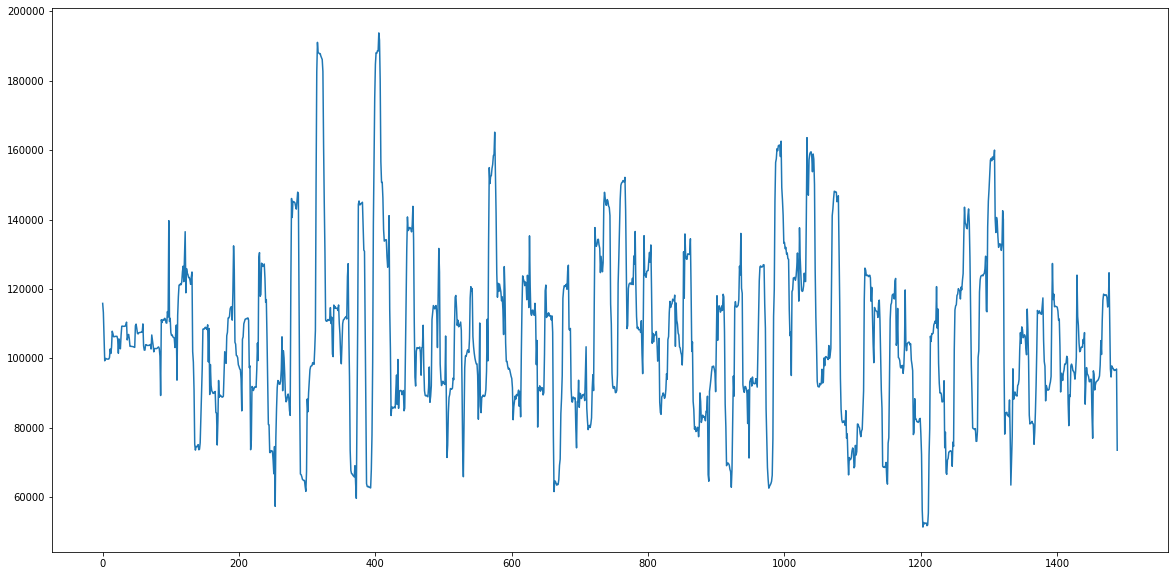

In [41]:
plt.plot(RFThree.values)

In [26]:
result_index = []
for k in range(d3):
    onset = k
    end = k + (n*f - (rolling_n - 1))
    
    a = RFThree.iloc[onset:end].values
    b = RFThree.iloc[end + (rolling_n - 1)]


    params,q = spiParametersMle(a)
    r = spiGeneratorParamMle([b], params, q)

    result_index.append(r)

In [33]:
d = np.ravel(np.array(result_index))

In [47]:
x = np.arange('1976-01', '2016-01', dtype='datetime64[M]')

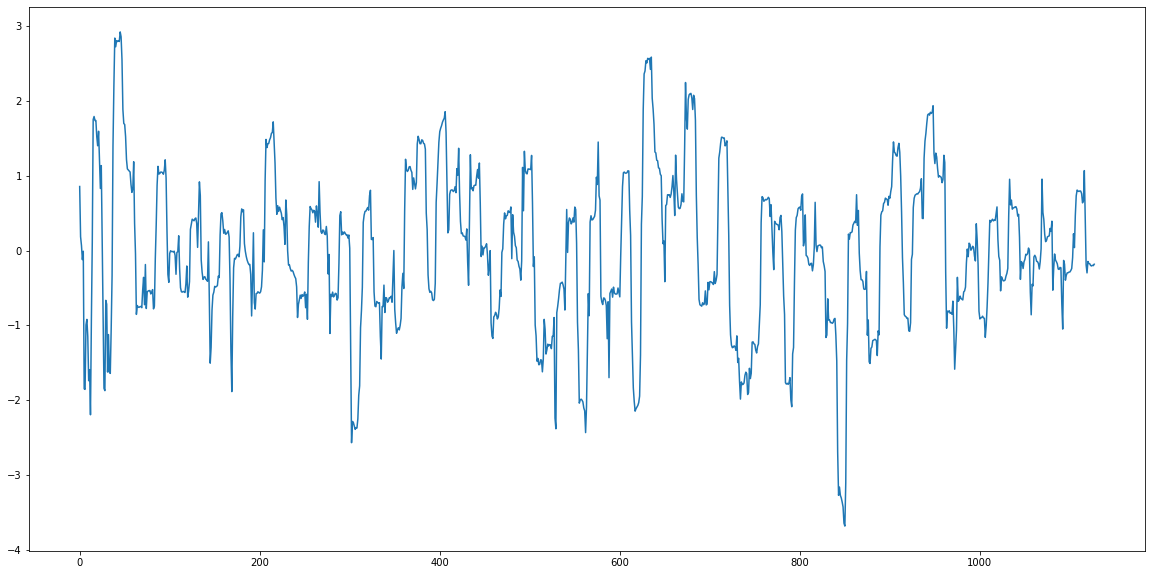

In [68]:
x = np.arange('1976-01', '2016-01', dtype='datetime64[M]')
plt.plot(d)

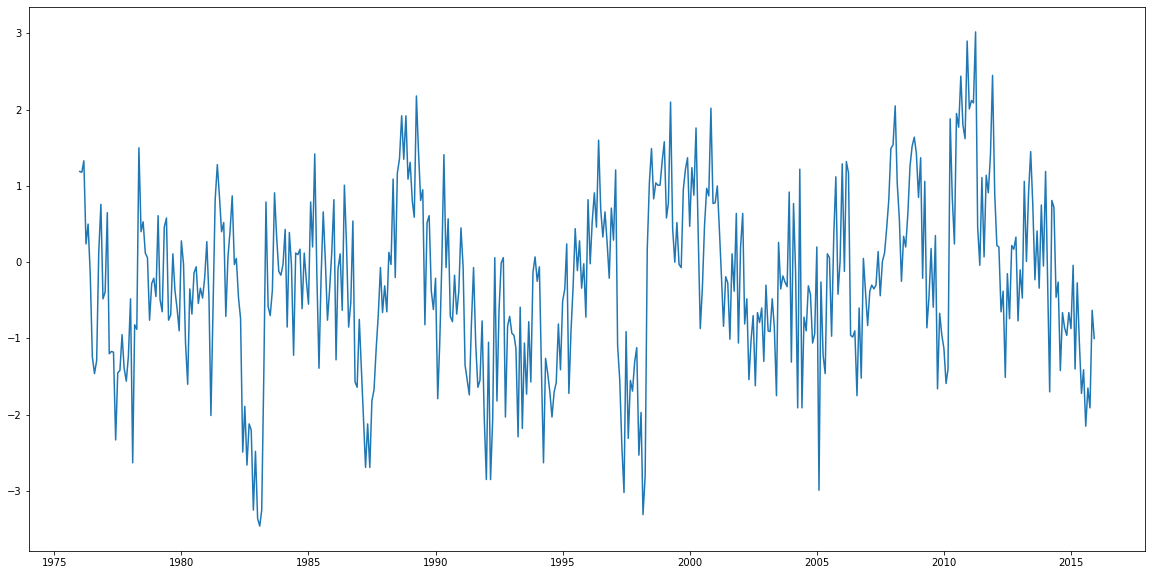

In [60]:
x = np.arange('1976-01', '2016-01', dtype='datetime64[M]')
plt.plot(x,soi)

In [52]:
 RFThree.iloc[end + (rolling_n - 1)]

96959.23970031738

In [57]:
soi = np.load("soi.npy")

In [54]:
soi.shape

(480,)

In [55]:
from scipy import stats

In [58]:
stats.pearsonr(d[-480:],soi)

(0.2294174771699353, 3.752438190499435e-07)

In [87]:
spi = np.load("ZW_gamma_18912015_12.npy")

In [88]:
spi[:,100]

array([2.32634787, 2.32634787, 2.32634787, ..., 0.54799135, 0.5284413 ,
       0.5803968 ])

In [73]:
class_list = np.load("ZW_class_list.npy")

In [75]:
class_list[100]

'BSh'

In [78]:
(2016-1922)*12

1128

In [79]:
spi.shape

(1128, 145)

In [91]:
np.where(np.isinf(spi[:,100]))

(array([ 12, 844, 845, 846, 847, 848, 849, 850, 851]),)

In [174]:
spi[12,100] < -1

True